<a href="https://colab.research.google.com/github/leandrominer85/Churn_Prediction/blob/main/Churn_Prediction_para_uma_empresa_de_Telecomunica%C3%A7%C3%B5es.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://raw.githubusercontent.com/carlosfab/escola-data-science/master/img/novo_logo_bg_claro.png">

#### **Data Science na Prática 3.0**
*by [sigmoidal.ai](https://sigmoidal.ai)*  

---

# Churn Prediction

*Churn rate*, ou simplesmente *churn*, representa a taxa de evasão da sua base de clientes. Em serviços como Spotify ou Netflix, ela representaria a taxa de cancelamento de assinaturas.

<p align=center>
<img src="https://raw.githubusercontent.com/carlosfab/dsnp2/master/img/churnrate.jpg" width="60%"></p>

Ela é de extrema importância para a administração e sua análise ao longo do tempo pode mostrar que existe algum problema que deve ser atacado.

*Churn* também pode ser usado para identificar potenciais cancelamentos, com um tempo de antecedência, e promover ações direcionadas para tentar reter tais clientes. Essa métrica deve receber atenção pelo fato de que o Custo de Aquisição de Cliente (CAC) é normalmente mais alto que o custo para mantê-los. Ou seja, um alto valor para o *churn rate* é o que não desejamos.

## Aquisição dos Dados

Os dados utilizados neste projeto foram originalmente disponibilizados na [plataforma de ensino da IBM Developer](https://developer.ibm.com/technologies/data-science/patterns/predict-customer-churn-using-watson-studio-and-jupyter-notebooks/#), e tratam de um problema típico de uma companhia de telecomunicações. O *dataset* completo pode ser encontrado [neste link](https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv).

Apesar de não haver informações explícitas disponíves, os nomes das colunas permitem um entendimento a respeito do problema.

In [ ]:
# Instalação dos pacotes
!pip install scikit-plot

In [ ]:
# Instalação dos pacotes
!pip install lightgbm

In [ ]:
# Instalação dos pacotes
!pip install xgboost

In [ ]:
# importar os pacotes necessários
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,confusion_matrix, classification_report
from sklearn.linear_model import  LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import LinearSVC
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
import scikitplot as skplt
from scikitplot.metrics import plot_confusion_matrix, plot_roc
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np

In [ ]:
# Estilizando o seaborn
sns.set_style('dark')

# Não mostrar mensagens de alerta "chatas"
warnings.filterwarnings('ignore')

In [ ]:
# importar os dados
DATA_PATH = "https://raw.githubusercontent.com/carlosfab/dsnp2/master/datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv"
df = pd.read_csv(DATA_PATH)

# ver as 5 primeiras entradas
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [ ]:
# Quais são as colunas?
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

## Dicionário de Variáveis

* customerID: Id do usuário
* gender: Gênero (female, male)
* SeniorCitizen: Usuário idoso ou não (1, 0)
* Partner: O consumidor possui um parceiro(a) (Yes, No)
* Dependents: O consumidor possui dependentes? (Yes, No)
* tenure: Número de meses que o consumidor manteve-se como cliente
* PhoneService: O consumidor possui linha telefônica? (Yes, No)
* MultipleLines: O consumidor possui múltiplas linhas telefônicas? (Yes, No, No phone service)
* InternetService: Provedor de internet do consumidor (DSL, Fiber optic, No)
* OnlineSecurity: O consumidor possui segurança online? (Yes, No, No internet service)
* OnlineBackup: O consumidor possui backup online? (Yes, No, No internet service)
* DeviceProtection: O consumidor possui proteção ao dispositivo? (Yes, No, No internet service)
* TechSupport: O consumidor possui assistência técnica? (Yes, No, No internet service)
* StreamingTV: O consumidor possui serviço de streaming de TV? (Yes, No, No internet service)
* StreamingMovies: O consumidor possui serviço de streaming de filmes? (Yes, No, No internet service)
* Contract: Tipo de contrato do consumidor (Month-to-month, One year, Two year)
* PaperlessBilling: Conta digital? (Yes, No)
* PaymentMethod: Método de pagamento (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
* MonthlyCharges: Total cobrado mensalmente ao consumidor
* TotalCharges: Cobrança total ao consumidor
* Churn: O consumidor desistiu do produto? (Yes or No)

## Análise exploratória

Antes de modicarmos os dados vou analisar como se encontra o dataframe.
Conforme a necessidade já farei algumas modificações simples.

In [ ]:
print("O dataframe possui {} linhas e {} colunas".format(df.shape[0],df.shape[1]))

O dataframe possui 7043 linhas e 21 colunas


In [ ]:
#Verificando valores ausentes
df.isnull().sum().sort_values(ascending=False)/len(df)

customerID          0.0
DeviceProtection    0.0
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
PaperlessBilling    0.0
Contract            0.0
StreamingMovies     0.0
StreamingTV         0.0
TechSupport         0.0
OnlineBackup        0.0
gender              0.0
OnlineSecurity      0.0
InternetService     0.0
MultipleLines       0.0
PhoneService        0.0
tenure              0.0
Dependents          0.0
Partner             0.0
SeniorCitizen       0.0
Churn               0.0
dtype: float64

In [ ]:
#Quais os tipos de variáveis?
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

In [ ]:
#A coluna TotalCharges precisa ser modificada para numérica. Mas
# isso dará em erros pois temos alguns dados vazios:
df.TotalCharges.sort_values()[0:15]

936           
3826          
4380          
753           
5218          
3331          
6754          
6670          
1340          
488           
1082          
105      100.2
4459    100.25
1723    100.35
2124     100.4
Name: TotalCharges, dtype: object

In [ ]:
# Transformando a coluna TotalCjarges para numérica
df['TotalCharges'] = pd.to_numeric(df.TotalCharges, errors='coerce')

In [ ]:
# Dessa forma a coluna contém valores nulos
df.TotalCharges.isnull().any()

True

In [ ]:
# Preenchendo os valores nulos com 0
df['TotalCharges'].fillna(0, inplace=True)

In [ ]:
# Retirando a coluna customerID pois apenas serve como identificador na base
df_drop = df.drop('customerID',axis=1)

In [ ]:
#Criando um dataframe apenas com os dados não numéricos
cat = df_drop.select_dtypes(['object'])

In [ ]:
# Verificando se os valores são condizentes com o dicionário
for col in cat:
    print(col, ": ", cat[col].unique())

gender :  ['Female' 'Male']
Partner :  ['Yes' 'No']
Dependents :  ['No' 'Yes']
PhoneService :  ['No' 'Yes']
MultipleLines :  ['No phone service' 'No' 'Yes']
InternetService :  ['DSL' 'Fiber optic' 'No']
OnlineSecurity :  ['No' 'Yes' 'No internet service']
OnlineBackup :  ['Yes' 'No' 'No internet service']
DeviceProtection :  ['No' 'Yes' 'No internet service']
TechSupport :  ['No' 'Yes' 'No internet service']
StreamingTV :  ['No' 'Yes' 'No internet service']
StreamingMovies :  ['No' 'Yes' 'No internet service']
Contract :  ['Month-to-month' 'One year' 'Two year']
PaperlessBilling :  ['Yes' 'No']
PaymentMethod :  ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Churn :  ['No' 'Yes']


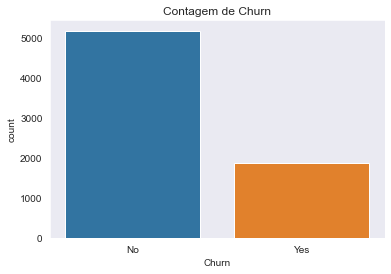

In [ ]:
#Verificando o balanceamento do dataset com relação à variável alvo (Class)
fig, ax = plt.subplots()
sns.countplot(data=df_drop,x="Churn")
ax.set_title("Contagem de Churn")
plt.plot();

In [ ]:
print("A taxa de Churn representa {:.4f}% das observações".format(len(df_drop[df_drop["Churn"]=='Yes'])/len(df)*100))

A taxa de Churn representa 26.5370% das observações


Como podemos ver o dataset é desbalanceado. Vamos proceder ao balanceamento mais à frente.

In [ ]:
df_drop.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692,2279.734304
std,0.368612,24.559481,30.090047,2266.794470
min,0.000000,0.000000,18.250000,0.000000
25%,0.000000,9.000000,35.500000,398.550000
50%,0.000000,29.000000,70.350000,1394.550000
75%,0.000000,55.000000,89.850000,3786.600000
max,1.000000,72.000000,118.750000,8684.800000


Dentre todo o dataset temos 4 variáveis classificadas como numéricas. Apesar disso, a variável SeniorCitizen é na verdade uma categórica já transformada.
A variável tenure é do tipo int enquanto MonthlyCharges e TotalCharges são do tipo float. As duas primeiras apresentam escalas próximas, já a TotalCharges está numa escala muito maior. Esses dados serão posteriormente normalizados.
Mas primeiro vamos verificar suas distribuições.

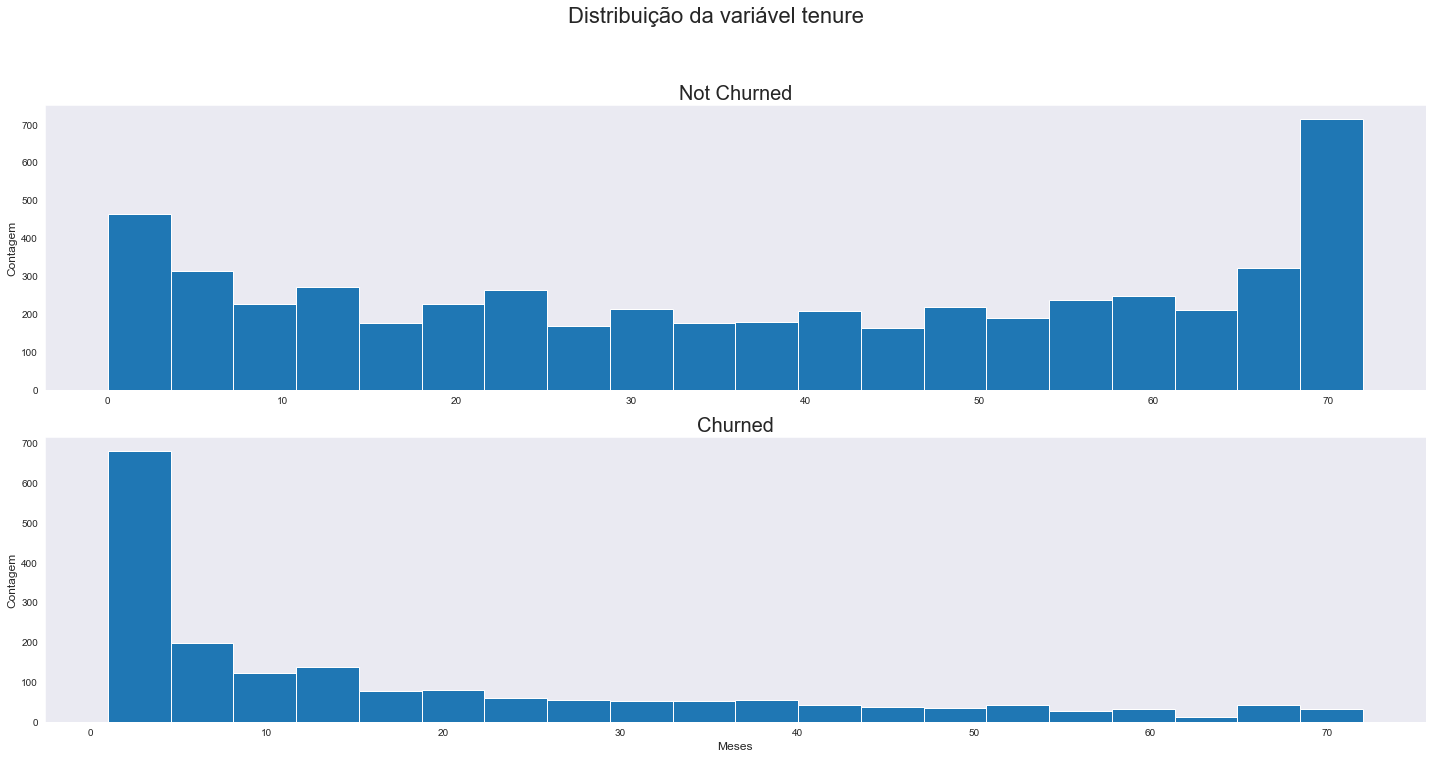

In [ ]:
# Analisando a distribuição da variável tenure para ambas categorias de fraude
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20,10))
ax[0].hist(df_drop['tenure'][df_drop['Churn']=='No'], bins =20) 
ax[0].set_title("Not Churned",fontsize=20)

ax[0].set_ylabel("Contagem",fontsize=12)

ax[1].set_title("Churned", fontsize=20)
ax[1].hist(df_drop['tenure'][df_drop['Churn']=='Yes'], bins= 20)

plt.xlabel("Meses", fontsize=12)

ax[1].set_ylabel("Contagem", fontsize=12)

fig.suptitle('Distribuição da variável tenure', fontsize=22 ,y=1.05)
plt.tight_layout();

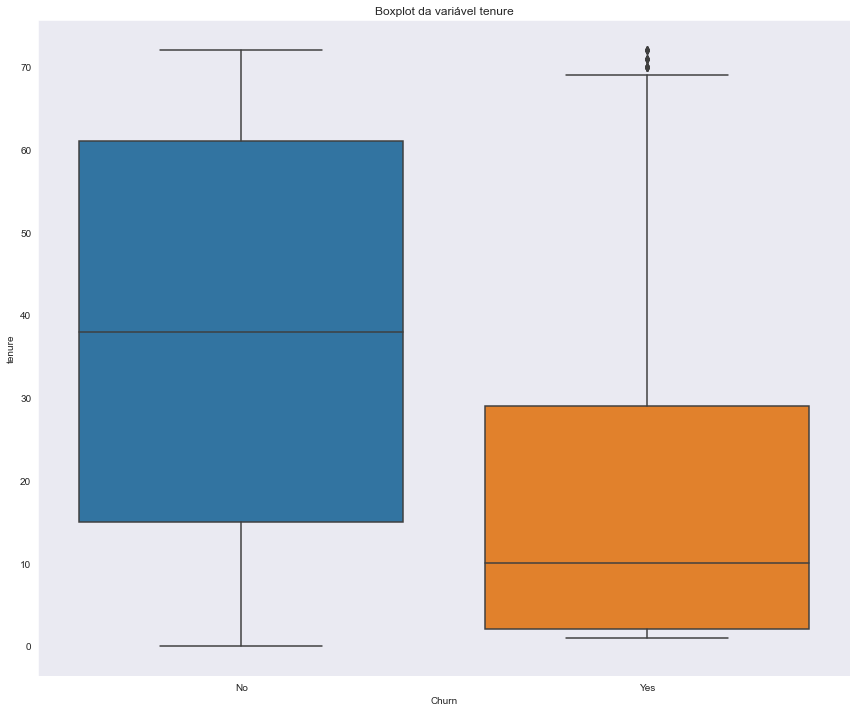

In [ ]:
# Boxplot da distribuição da variável tenure por classe
fig, ax = plt.subplots( figsize=(12,10) )
sns.boxplot(y='tenure', data=df_drop,x='Churn').set_title('Boxplot da variável tenure')
plt.tight_layout();

Tenure se refere ao total de meses que o consumidor ficou na empresa. Tanto o histograma quanto o boxplot mostram que entre aqueles que se mantiveram na empresa (not churned) a distribuição é mais homogênea e não apresenta outliers. Já para aqueles com churn positivo a distribuição é desviada para a esquerda e existe a presença de outliers.

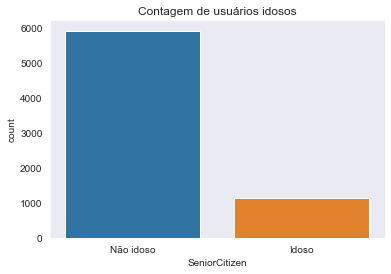

In [ ]:
#Verificando o balanceamento do dataset com relação à variável SeniorCitizen
fig, ax = plt.subplots()
sns.countplot(data=df_drop,x="SeniorCitizen")
ax.set_title("Contagem de usuários idosos")
plt.xticks([0,1],['Não idoso',"Idoso"])
plt.plot();

Podemos ver que a presença de usuários não idosos é muito maior que a de idosos. Mas por não se tratar da variável-alvo não há problema.

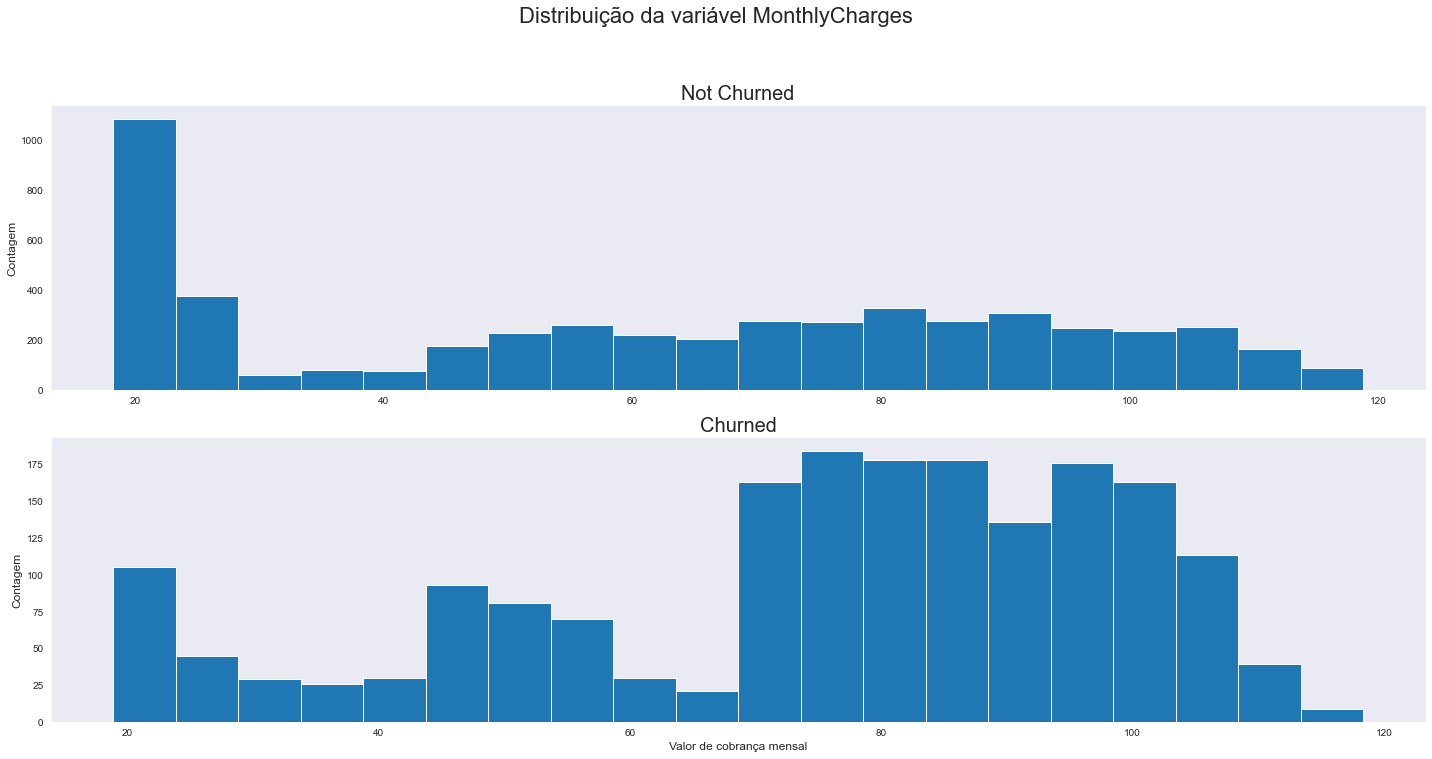

In [ ]:
# Analisando a distribuição da variável MonthlyCharges para ambas categorias de Churn
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20,10))
ax[0].hist(df_drop['MonthlyCharges'][df_drop['Churn']=='No'], bins =20) 
ax[0].set_title("Not Churned",fontsize=20)

ax[0].set_ylabel("Contagem",fontsize=12)

ax[1].set_title("Churned", fontsize=20)
ax[1].hist(df_drop['MonthlyCharges'][df_drop['Churn']=='Yes'], bins= 20)

plt.xlabel("Valor de cobrança mensal", fontsize=12)

ax[1].set_ylabel("Contagem", fontsize=12)

fig.suptitle('Distribuição da variável MonthlyCharges', fontsize=22 ,y=1.05)
plt.tight_layout();

A subdivisão da variável entre Churned e not Churned faz com que os grupos difiram em relação aos limites das observações. Apesar disso, podemos ver que a cobrança mensal tem um forte pico à esquerda da distribuição no grupo not Churned enquanto no grupo Churned as concentrações aparecem mais à direita (maior gasto mensal). Isso pode indicar uma relação entre valores e desistência. 

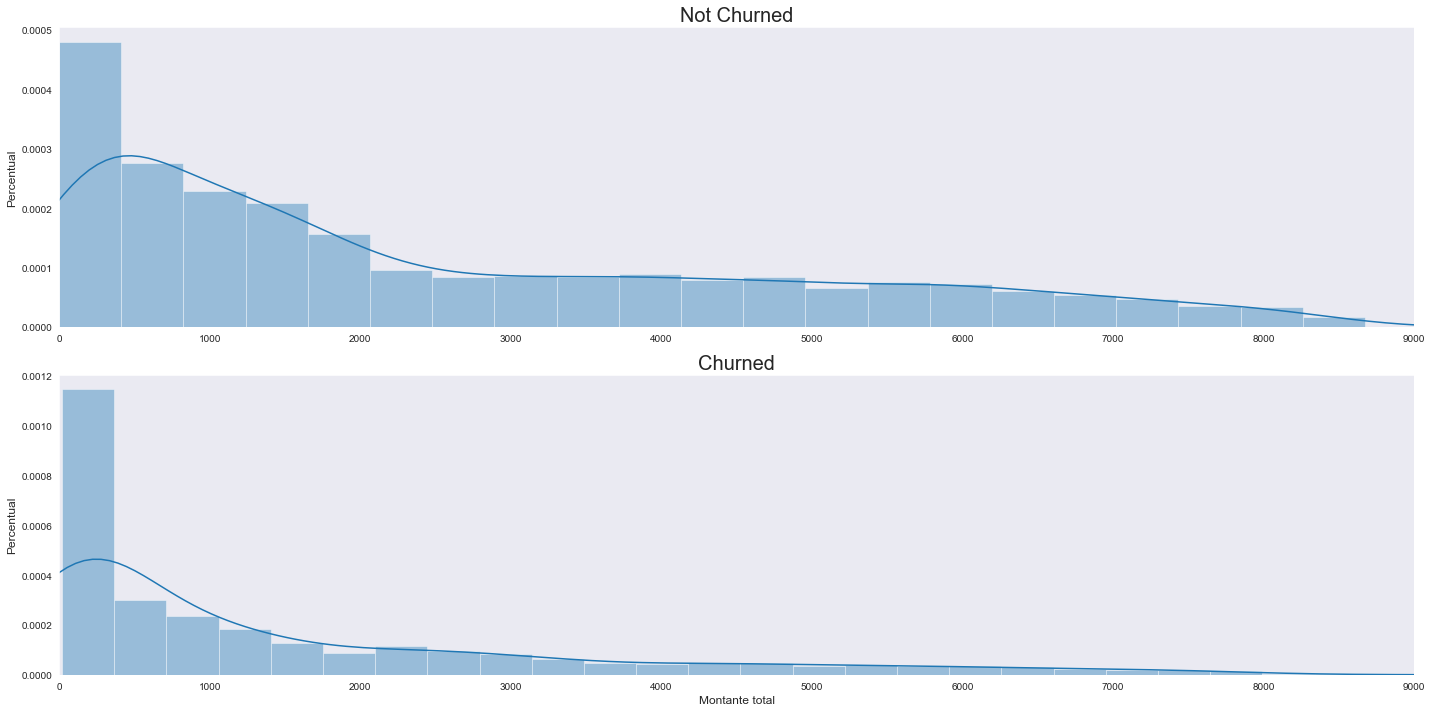

In [ ]:
# Analisando a distribuição da variável TotalCharges para ambas categorias de Churn
fig, ax = plt.subplots(nrows=2,ncols=1, figsize=(20,10) )
sns.distplot(df['TotalCharges'][df['Churn']=='No'], ax=ax[0])
ax[0].set_title("Not Churned", fontsize=20)
ax[0].set_xlabel("")
ax[0].set_ylabel("Percentual" ,fontsize=12)
ax[0].set_xlim(0, 9000)


ax[1].set_title("Churned", fontsize=20)
sns.distplot(df['TotalCharges'][df['Churn']=='Yes'],ax=ax[1])



ax[1].set_ylabel("Percentual",fontsize=12)
plt.xlabel("Montante total",fontsize=12)
ax[1].set_xlim(0, 9000)
plt.tight_layout();

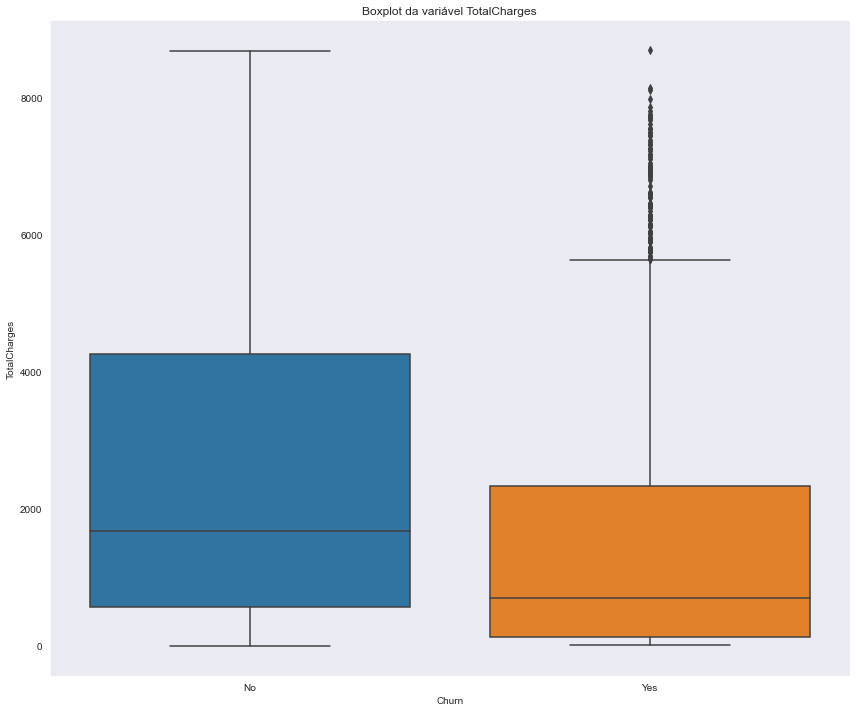

In [ ]:
# Boxplot da distribuição do montante total por classe
fig, ax = plt.subplots( figsize=(12,10) )
sns.boxplot(y='TotalCharges', data=df_drop,x='Churn').set_title('Boxplot da variável TotalCharges')
plt.tight_layout();

Pelo gráfico de distribuição o grupo Churned tem uma clara concentração à direita -o que é de se esperar dado que tendem a acumular menos gastos por terem deixado de serem clientes. No outro sentido o grupo not Churned tem uma distribuição mais alongada. Claro que essa variável depende da tenure - pois com o tempo o montante total aumenta.
O boxplot do grupo Churned mostra uma grande presença de outliers. Analisando esse gráfico com o boxplot de tenure faz com que a escolha por um algoritimo de normalização recaia sobre o StandardScaler que é menos sensível a outliers.

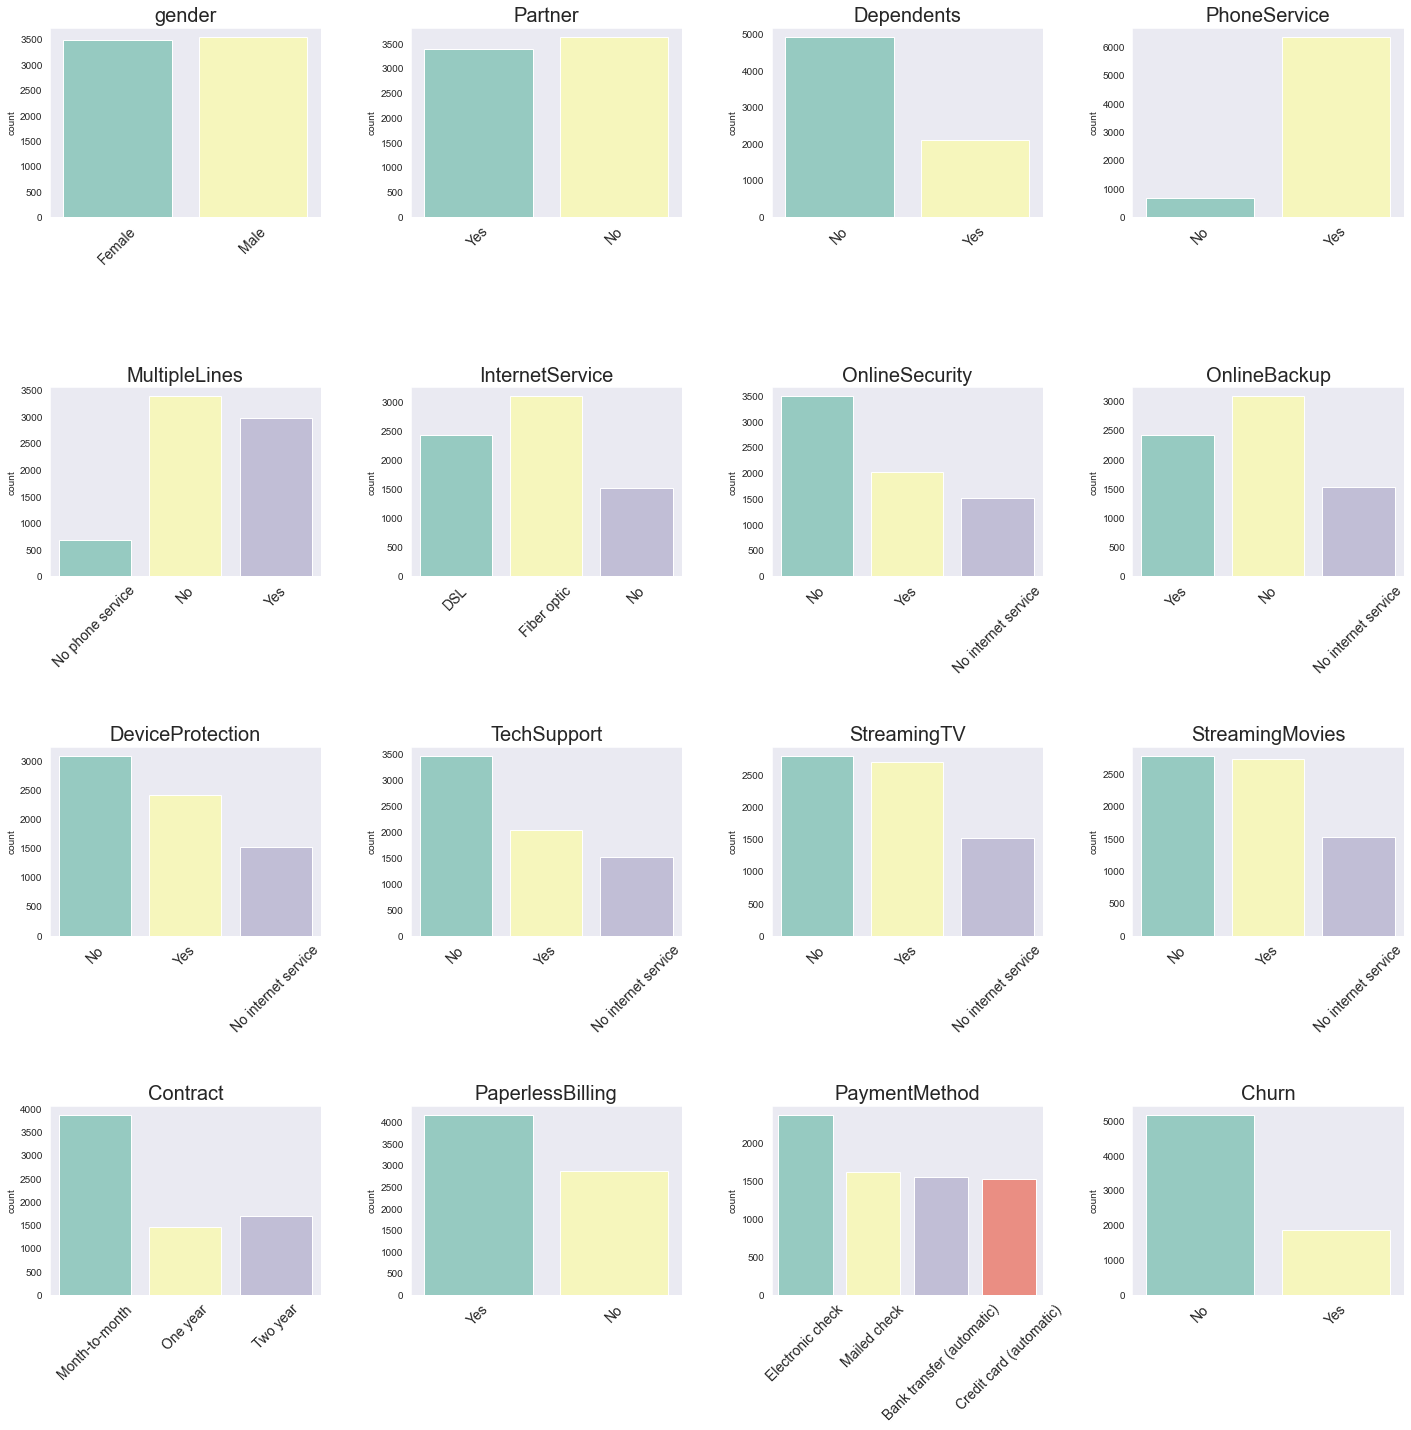

In [ ]:
#Distribuição cumulativa das variáveis

fig, ax = plt.subplots(nrows=4,ncols=4, figsize=[20,20])
fig.subplots_adjust(hspace=1, wspace=1)

for n,i in enumerate(cat.columns):
    plt.subplot(4,4,n+1)
    sns.countplot(data=cat,x=i,orient='h', palette="Set3")
    plt.title(i, fontsize=20)
    plt.xlabel('')
    plt.xticks(rotation=45, fontsize=14)
plt.tight_layout(pad=1.2, h_pad=5);

Há um certo equilíbrio entre as classes da maioria das variáveis categóricas. Além da presença de linha telefônica, que, dado o ramo da empresa, aparece muito concentrada no sim, é interessante notar qe a maior parte dos contratos é mensal - de curto prazo portanto.

## Processamento dos dados

Antes de proceder à construção do modelo de machine learning é preciso transformar os dados. Esse processo envolve tanto a codificação das variáveis categóricas quanto a posterior normalização das variáveis numéricas (que será incorporado no pipeline do modelo).

In [ ]:
# criar uma cópia do dataframe
df_proc = df_drop.copy()

# Label Encoding para as variáveis Binárias
le = LabelEncoder()
for i in cat.columns:
  if len(cat[i].unique()) == 2:
    df_proc[i] = le.fit_transform(df_proc[i])
  else:
    df_proc = pd.get_dummies(df_proc, columns=[i])


# ver as 5 primeiras entradas do novo dataframe
df_proc.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,0,1,0,1,0,1,29.85,29.85,0,...,1,0,0,1,0,0,0,0,1,0
1,1,0,0,0,34,1,0,56.95,1889.50,0,...,1,0,0,0,1,0,0,0,0,1
2,1,0,0,0,2,1,1,53.85,108.15,1,...,1,0,0,1,0,0,0,0,0,1
3,1,0,0,0,45,0,0,42.30,1840.75,0,...,1,0,0,0,1,0,1,0,0,0
4,0,0,0,0,2,1,1,70.70,151.65,1,...,1,0,0,1,0,0,0,0,1,0


Como estão as correlações antes da normalização do dataset?

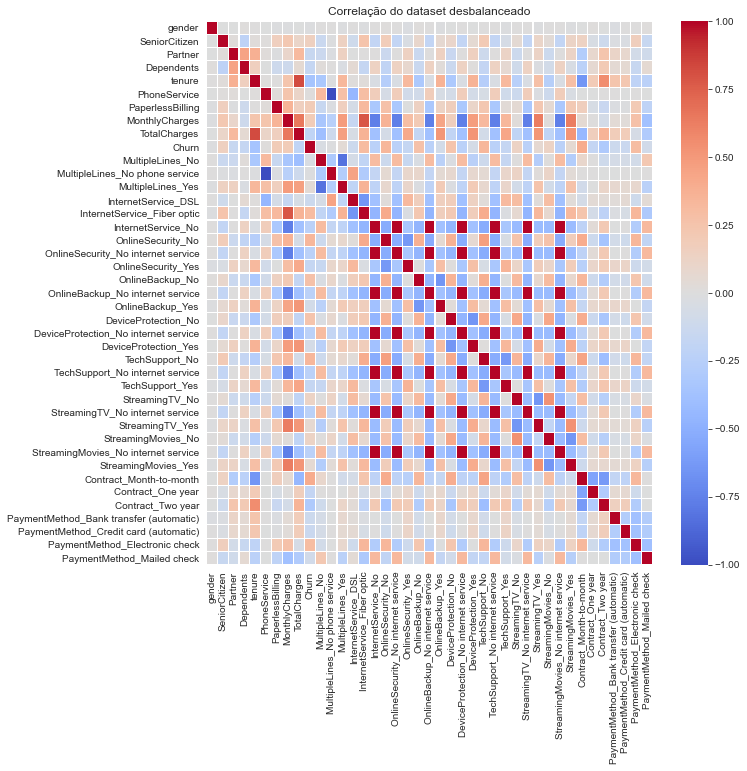

In [ ]:
# Analisando as correlações
plt.subplots(figsize=(10,10))
corr = df_proc.corr()
sns.heatmap(corr,cmap='coolwarm', linewidths=.1)
plt.title("Correlação do dataset desbalanceado")
plt.show();

In [ ]:
corr['Churn'].sort_values()

tenure                                    -0.352229
Contract_Two year                         -0.302253
OnlineBackup_No internet service          -0.227890
InternetService_No                        -0.227890
DeviceProtection_No internet service      -0.227890
TechSupport_No internet service           -0.227890
StreamingTV_No internet service           -0.227890
StreamingMovies_No internet service       -0.227890
OnlineSecurity_No internet service        -0.227890
TotalCharges                              -0.198324
Contract_One year                         -0.177820
OnlineSecurity_Yes                        -0.171226
TechSupport_Yes                           -0.164674
Dependents                                -0.164221
Partner                                   -0.150448
PaymentMethod_Credit card (automatic)     -0.134302
InternetService_DSL                       -0.124214
PaymentMethod_Bank transfer (automatic)   -0.117937
PaymentMethod_Mailed check                -0.091683
OnlineBackup

Pelo menos a princípio as variáveis marcadoras de tempo, tenure e contract, parecem ter correlações interessantes. Vejamos como isso se mantêm após a transformação do dataframe.
Para tanto irei dividir o dataset em treino e teste e criar novos dataframes a partir de três técnicas de balanceamento.

In [ ]:
# Divisão entre treino e teste
X = df_proc.drop('Churn', axis =1)
y = df_proc.Churn
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,stratify=y)

In [ ]:
# A variável de controle continua desbalanceada 
y_train.value_counts()

0    3622
1    1308
Name: Churn, dtype: int64

In [ ]:
# Técnica mista
#https://imbalanced-learn.org/stable/combine.html
smote_enn = SMOTEENN(random_state=42)
X_resampled_smote, y_resampled_smote = smote_enn.fit_resample(X_train, y_train)

In [ ]:
# Undersampling
rus = RandomUnderSampler(random_state=42)
X_resampled_under, y_resampled_under = rus.fit_resample(X_train, y_train)

In [ ]:
# OverSampling
ros = RandomOverSampler(random_state=42)
X_resampled_over, y_resampled_over = ros.fit_resample(X_train, y_train)

In [ ]:
# Utilizando uma para verificar o balanceamento
y_resampled_smote.value_counts()

1    2240
0    1898
Name: Churn, dtype: int64

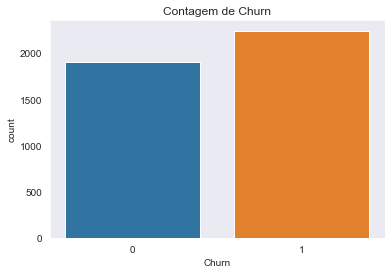

In [ ]:
#Verificando o balanceamento do novo dataset
fig, ax = plt.subplots()
sns.countplot(y_resampled_smote)
ax.set_title("Contagem de Churn")
plt.plot();

### Correlações no dataset balanceado

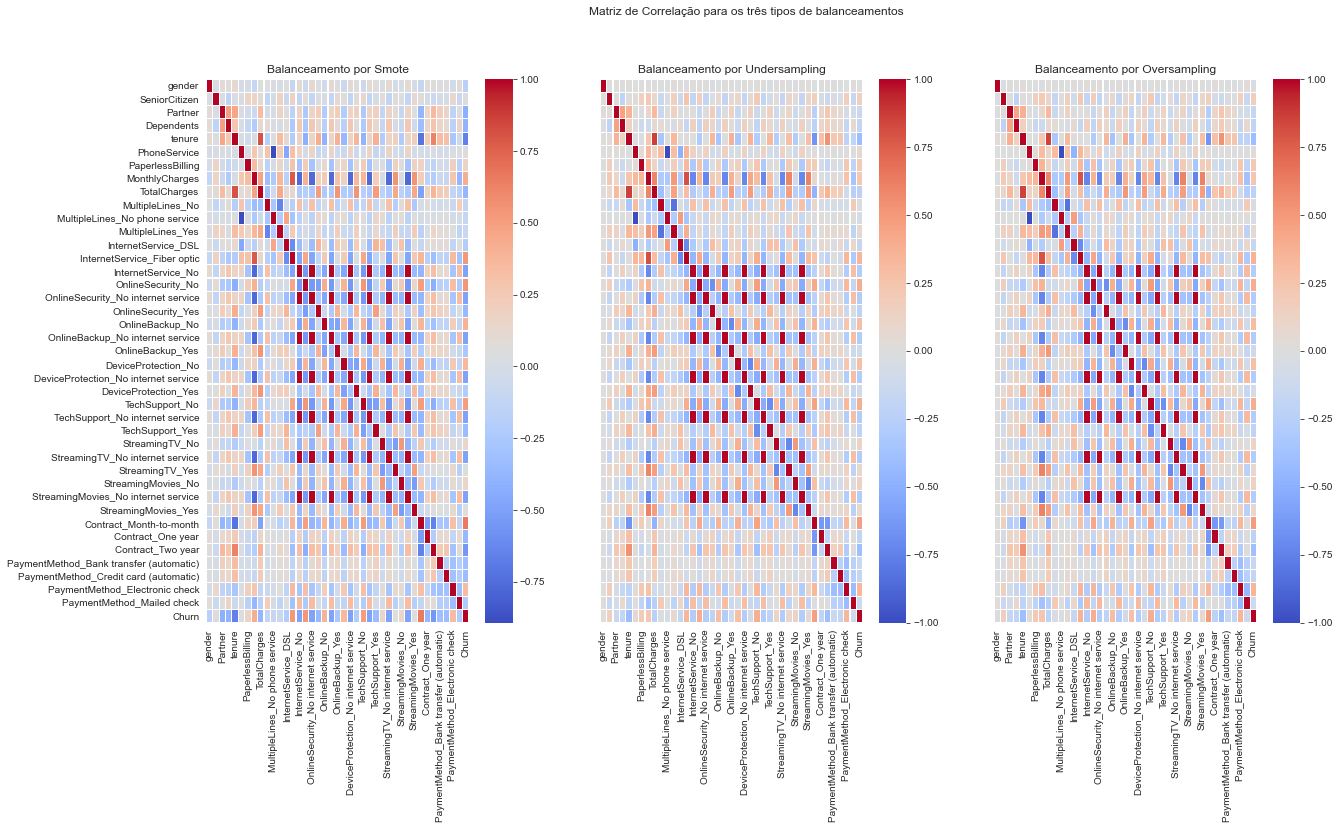

In [ ]:
smote=X_resampled_smote.copy()
under=X_resampled_under.copy()
over=X_resampled_over.copy()

smote["Churn"] = y_resampled_smote
under["Churn"] = y_resampled_under
over["Churn"] = y_resampled_over

corr_smote = smote.corr()
corr_under = under.corr()
corr_over = over.corr()

fig, ax = plt.subplots(nrows=1, ncols=3, figsize = (20,10))
fig.suptitle('Matriz de Correlação para os três tipos de balanceamentos')

sns.heatmap(corr_smote, linewidths=.1, cmap="coolwarm", ax=ax[0])
ax[0].set_title('Balanceamento por Smote')

sns.heatmap(corr_under, linewidths=.1, cmap="coolwarm", ax=ax[1],yticklabels=False)
ax[1].set_title('Balanceamento por Undersampling')




sns.heatmap(corr_over, linewidths=.1, cmap="coolwarm", ax=ax[2], yticklabels=False)
ax[2].set_title('Balanceamento por Oversampling')

plt.show();

In [ ]:
corr_under['Churn'].sort_values()

tenure                                    -0.410535
Contract_Two year                         -0.391000
StreamingMovies_No internet service       -0.276691
OnlineBackup_No internet service          -0.276691
TechSupport_No internet service           -0.276691
OnlineSecurity_No internet service        -0.276691
InternetService_No                        -0.276691
StreamingTV_No internet service           -0.276691
DeviceProtection_No internet service      -0.276691
TotalCharges                              -0.231363
OnlineSecurity_Yes                        -0.214968
TechSupport_Yes                           -0.203179
Contract_One year                         -0.196092
Dependents                                -0.185799
PaymentMethod_Credit card (automatic)     -0.177019
InternetService_DSL                       -0.157494
Partner                                   -0.148167
PaymentMethod_Bank transfer (automatic)   -0.134625
PaymentMethod_Mailed check                -0.107967
OnlineBackup

As correlações vistas antes ganham mais força com o balanceamento. Também aparecem outras como Online Security. Esses dados poderiam ser utilizados para proceder uma limpeza da base para reduzi-la a variáveis com maior poder explicativo, mas esse não é o foco no momento.

## Modelos de ML

Para essa etapa optei por criar uma função que utiliza o dataset dividido em treino e teste como entrada. Utiliza um pipeline para standarizar as duas variáveis que necessitamos e retorna diversas estatísticas com os parâmetros base e random state = 42 para os seguintes modelos: LogisticRegression, DecisionTreeClassifier, RandomForestClassifier, LinearSVC , Adaboost, XGBClassifier e LGBMClassifier

In [ ]:
def baseline_ml(X_train, X_test, y_train, y_test):
            
    '''
    Utiliza os dados da divisão de treinamento / teste. Por meio de um pipeline faz a transformação das colunas
    numéricas não standarizadas utilizando o StandardScaler.
    Faz o fit em 5 algoritmos de aprendizado de máquina
    com as configurações padrão e random state = 42: LogisticRegression, DecisionTreeClassifier,
    RandomForestClassifier, LinearSVC , Adaboost, XGBClassifier e LGBMClassifier.  Para cada um dos modelos imprime os scores : accuracy,  f1-score,
    precision, recall e roc_auc_score, bem como a matriz de confisão.

    Parâmetros:
    X_train - Variáveis de treino
    X_test - Variáveis de teste
    y_train - Variável alvo de treino
    y_test - Variável alvo de teste
    
    
    Retorna - Print dos parâmetros
    '''
    
    
   
    # Initialize models
    clf_LR = LogisticRegression(random_state=42)
    clf_DT = DecisionTreeClassifier(random_state=42)
    clf_RF = RandomForestClassifier(random_state=42)
    clf_SVC = LinearSVC(random_state=42)
    clf_ADA = AdaBoostClassifier(random_state=42)
    clf_XGB = XGBClassifier(random_state=42)
    clf_LGBM = LGBMClassifier(random_state=42)
    

    #Empty dic for the results
    results = {}

    for clf in [clf_LR, clf_DT, clf_RF, clf_SVC, clf_ADA, clf_XGB,clf_LGBM]:
        model_results = {}
        
        # get the classifier name
        clf_name = clf.__class__.__name__
        
        
        numeric_features = ['tenure'	,'MonthlyCharges'	,'TotalCharges']
        numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])


        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features)])

        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor)])



        preprocessor = ColumnTransformer(
            transformers=[
                ('num', numeric_transformer, numeric_features)])

        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('classificator', clf)
        ])

        model = pipe.fit(X_train,y_train)
        y_pred = model.predict(X_test)

        
        model_results['accuracy'] = accuracy_score(y_test, y_pred)
        model_results['precision'] = precision_score(y_test, y_pred)
        model_results['recall'] = recall_score(y_test, y_pred)
        model_results['f1'] = f1_score(y_test, y_pred)
        model_results['roc_auc'] = roc_auc_score(y_test, y_pred)
        

        print(clf_name)
        print('Accuracy: ',model_results['accuracy'])
        print('Precision: ',model_results['precision'])
        print('Recall: ',model_results['recall'])
        print('F1: ',model_results['f1'])
        print('Roc_auc: ',model_results['roc_auc'])
        print('')
        skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True, title = clf_name)
        results[clf_name] = model_results
    
    

LogisticRegression
Accuracy:  0.7004259346900142
Precision:  0.4625779625779626
Recall:  0.7932263814616756
F1:  0.5843729481286934
Roc_auc:  0.7300539123803224

DecisionTreeClassifier
Accuracy:  0.6956933270231898
Precision:  0.45403587443946186
Recall:  0.7219251336898396
F1:  0.5574673090158292
Roc_auc:  0.7040682369480126

RandomForestClassifier
Accuracy:  0.702318977756744
Precision:  0.46205357142857145
Recall:  0.7379679144385026
F1:  0.5682910089224433
Roc_auc:  0.7137004520646121

LinearSVC
Accuracy:  0.6975863700899195
Precision:  0.4597107438016529
Recall:  0.7932263814616756
F1:  0.5820797907128843
Roc_auc:  0.7281209226896006

AdaBoostClassifier
Accuracy:  0.6900141978230004
Precision:  0.4515463917525773
Recall:  0.7807486631016043
F1:  0.5721750489875899
Roc_auc:  0.7189825789734825

[23:28:35] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary

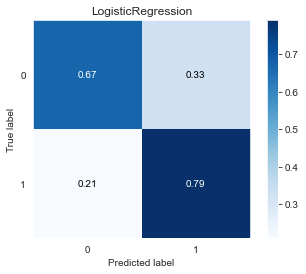

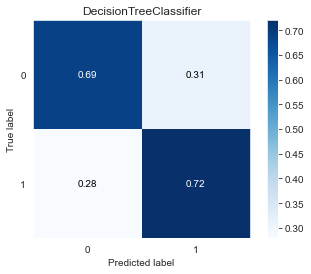

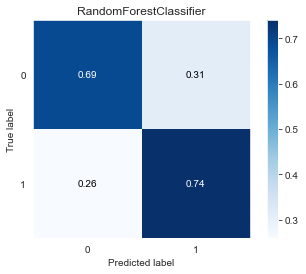

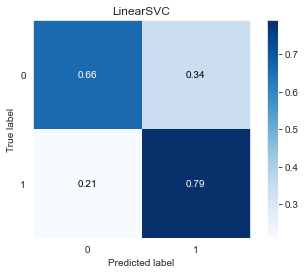

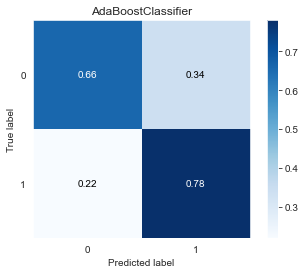

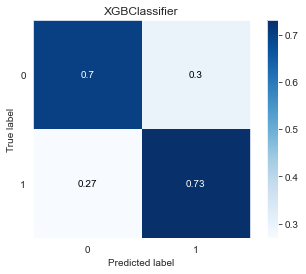

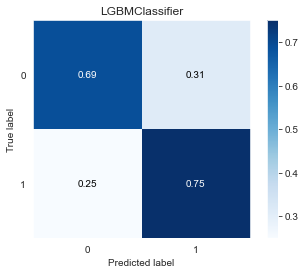

In [ ]:
# Modelo com Smote
baseline_ml(X_resampled_smote, X_test, y_resampled_smote, y_test)

LogisticRegression
Accuracy:  0.7155702792238523
Precision:  0.4766899766899767
Recall:  0.7290552584670231
F1:  0.5764622973925299
Roc_auc:  0.7198755673778414

DecisionTreeClassifier
Accuracy:  0.6483672503549456
Precision:  0.40380549682875266
Recall:  0.6809269162210339
F1:  0.5069674850696748
Roc_auc:  0.6587624271826817

RandomForestClassifier
Accuracy:  0.7061050638902036
Precision:  0.46598639455782315
Recall:  0.732620320855615
F1:  0.5696465696465697
Roc_auc:  0.7145704697061579

LinearSVC
Accuracy:  0.7179365830572646
Precision:  0.47928994082840237
Recall:  0.7219251336898396
F1:  0.5761024182076814
Roc_auc:  0.7192099895253321

AdaBoostClassifier
Accuracy:  0.7212494084240416
Precision:  0.48423423423423423
Recall:  0.7664884135472371
F1:  0.5935127674258109
Roc_auc:  0.7356926603818659

[23:28:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'bina

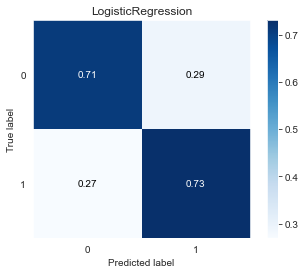

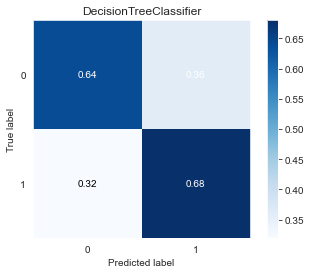

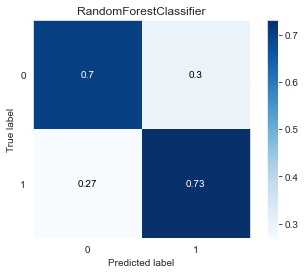

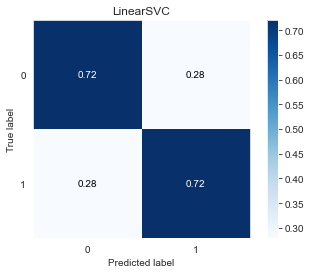

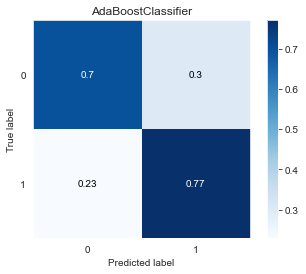

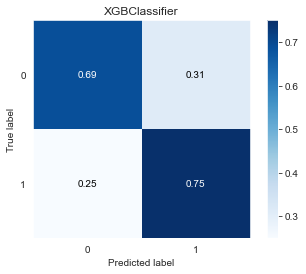

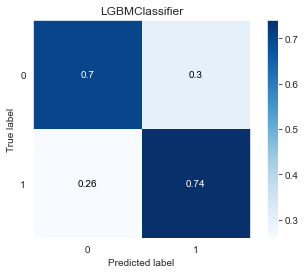

In [ ]:
# Modelo com Undersampling
baseline_ml(X_resampled_under, X_test, y_resampled_under, y_test)

LogisticRegression
Accuracy:  0.7146237576904875
Precision:  0.4756944444444444
Recall:  0.732620320855615
F1:  0.5768421052631578
Roc_auc:  0.7203694387783229

DecisionTreeClassifier
Accuracy:  0.7132039753904401
Precision:  0.4626865671641791
Recall:  0.49732620320855614
F1:  0.4793814432989691
Roc_auc:  0.6442816583053089

RandomForestClassifier
Accuracy:  0.7397065783246569
Precision:  0.5091819699499165
Recall:  0.5436720142602496
F1:  0.5258620689655172
Roc_auc:  0.677119512284764

LinearSVC
Accuracy:  0.7165168007572172
Precision:  0.47790697674418603
Recall:  0.732620320855615
F1:  0.5784658691062632
Roc_auc:  0.7216580985721373

AdaBoostClassifier
Accuracy:  0.7231424514907714
Precision:  0.4858823529411765
Recall:  0.7361853832442068
F1:  0.5854004252303331
Roc_auc:  0.7273066091478766

[23:28:43] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:l

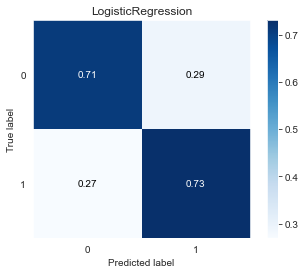

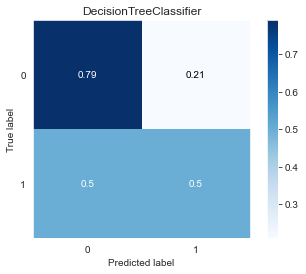

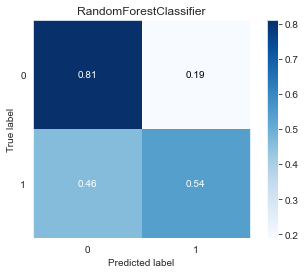

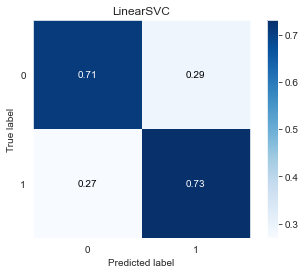

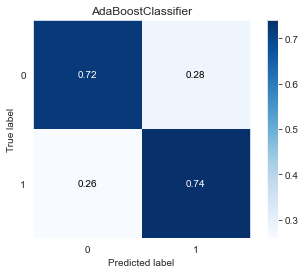

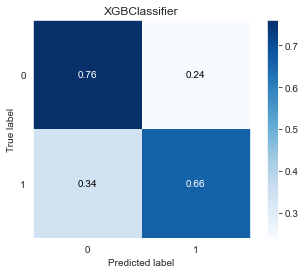

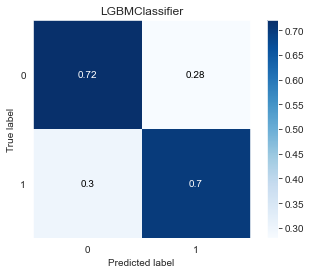

In [ ]:
# Modelo com Oversampling
baseline_ml(X_resampled_over, X_test, y_resampled_over, y_test)

## Avaliação dos modelos

A escolha da métrica de avaliação de um modelo de aprendizado de máquina deve ser atrelada ao problema que se quer atacar.
Por se tratar de uma um projeto de detecção de fraudes, que lesam tanto o cliente quanto as empresas, queremos minimizar a presença de falsos negativos - quando se trata de uma fraude mas classificamos como normal.
Por isso, a métrica principal que levei em conta na escolha dos modelos foi Recall:
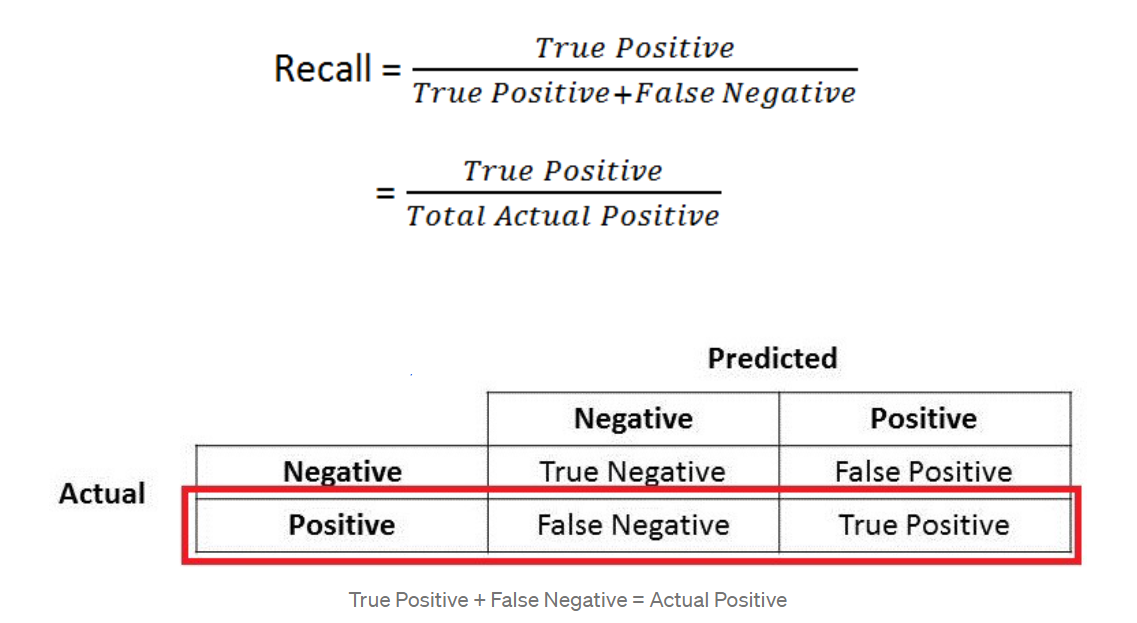


Pensando nessa métrica e avaliando os resultados entre as três técnicas de sampling o Adaboost apresenta os melhores resultados em geral:. O melhor resultado sendo com Smote:


| AdaBoostClassifier |                      |
|--------------------|----------------------|
| Accuracy:          | 0.6952200662565073   |
| Precision:         | 0.4591937069813176 |
| Recall:            | 0.8324420677361853    |
| F1:                | 0.5918884664131813  |
| Roc_auc:           | 0.7390303122186082   |





Vamos proceder agora ao tunning dos hiperparâmetros.

In [ ]:

abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

parametros = {"modelo__base_estimator__criterion":['gini', 'entropy'],
              'modelo__base_estimator__max_depth':list(np.arange(1,200,50))+['None'],
              'modelo__base_estimator__min_samples_leaf':np.arange(1,10,2),
              'modelo__base_estimator__min_samples_split':np.arange(1,10,2),
              'modelo__base_estimator__random_state': [42]}




pipe = Pipeline(steps=[('modelo', abc)
])

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid=parametros, cv=kfold, return_train_score=True, scoring="recall", n_jobs=6)
grid.fit(X=X_resampled_smote, y=y_resampled_smote)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('modelo',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))]),
             n_jobs=6,
             param_grid={'modelo__base_estimator__criterion': ['gini',
                                                               'entropy'],
                         'modelo__base_estimator__max_depth': [1, 51, 101, 151,
                                                               'None'],
                         'modelo__base_estimator__min_samples_leaf': array([1, 3, 5, 7, 9]),
                         'modelo__base_estimator__min_samples_split': array([1, 3, 5, 7, 9]),
                         'modelo__base_estimator__random_state': [42]},
             return_train_score=True, scoring='recall')

In [ ]:
grid.best_estimator_

Pipeline(steps=[('modelo',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                          max_depth=51,
                                                                          min_samples_split=3,
                                                                          random_state=42)))])

In [ ]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier())

parametros = {'modelo__n_estimators':[10,50,250,1000],
              'modelo__learning_rate':np.arange(0.1,100.5,0.9)}



pipe = Pipeline(steps=[('modelo', abc)
])

kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid = GridSearchCV(pipe, param_grid=parametros, cv=kfold, return_train_score=True, scoring="recall", n_jobs=6)
grid.fit(X=X_resampled_smote, y=y_resampled_smote)


GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('modelo',
                                        AdaBoostClassifier(base_estimator=DecisionTreeClassifier()))]),
             n_jobs=6,
             param_grid={'modelo__learning_rate': array([  0.1,   1. ,   1.9,   2.8,   3.7,   4.6,   5.5,   6.4,   7.3,
         8.2,   9.1,  10. ,  10.9,  11.8,  12.7,  13.6,  14.5,  15.4,
        16.3,  17.2,  18.1,  19. ,  19.9,  20.8,  21.7,  22.6,  23.5,
        24.4...
        48.7,  49.6,  50.5,  51.4,  52.3,  53.2,  54.1,  55. ,  55.9,
        56.8,  57.7,  58.6,  59.5,  60.4,  61.3,  62.2,  63.1,  64. ,
        64.9,  65.8,  66.7,  67.6,  68.5,  69.4,  70.3,  71.2,  72.1,
        73. ,  73.9,  74.8,  75.7,  76.6,  77.5,  78.4,  79.3,  80.2,
        81.1,  82. ,  82.9,  83.8,  84.7,  85.6,  86.5,  87.4,  88.3,
        89.2,  90.1,  91. ,  91.9,  92.8,  93.7,  94.6,  95.5,  96.4,
        97.3,  98.2,  99.1, 100. ]),
             

In [ ]:
grid.best_estimator_

Pipeline(steps=[('modelo',
                 AdaBoostClassifier(base_estimator=DecisionTreeClassifier(),
                                    learning_rate=1.9000000000000001,
                                    n_estimators=1000))])

Com os parâmetros em mãos vamos criar o modelo. Lembrando que por se tratar de algoritmos baseados em árvores não é preciso o pré-processamento:
https://towardsdatascience.com/the-ultimate-guide-to-adaboost-random-forests-and-xgboost-7f9327061c4f

              precision    recall  f1-score   support

           0       0.89      0.75      0.82      1552
           1       0.52      0.75      0.62       561

    accuracy                           0.75      2113
   macro avg       0.71      0.75      0.72      2113
weighted avg       0.80      0.75      0.76      2113


Recall: 0.7525

AUC: 0.7525




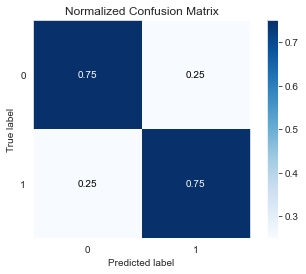

In [ ]:
abc = AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                          max_depth=51,
                                                                          min_samples_split=7,
                                                                          random_state=42),
                         learning_rate=2, n_estimators=1000)

abc.fit(X_resampled_smote, y_resampled_smote)


y_pred = abc.predict(X_test)


print(classification_report(y_test, y_pred))
print('')
print("Recall: {:.4f}\n".format(recall_score(y_test, y_pred, average='macro')))
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))
print('')
# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

Com o tunning o modelo aumentou em relação ao modelo base no parâmetro Recall em ROC-AUC e em acurácia. Vamos testar um modelo com XGBClassifier para ter outra base de comparação.

In [ ]:
xgb = XGBClassifier(random_state=42)

param_grid = {'gamma':[i/10.0 for i in range(0,5)]}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=6, cv=kfold)
grid_result = grid_search.fit(X_resampled_smote, y_resampled_smote)

[14:06:28] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
grid_result.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
xgb = XGBClassifier(gamma=0.0,random_state=42)

param_grid = {'learning_rate':[0.001, 0.01, 0.1, 1]}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=6, cv=kfold)
grid_result = grid_search.fit(X_resampled_smote, y_resampled_smote)

[14:07:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
grid_result.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
xgb = XGBClassifier(gamma=0.1, learning_rate = 0.1,random_state=42)

param_grid = {'max_depth':range(1,8,1)}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=6, cv=kfold)
grid_result = grid_search.fit(X_resampled_smote, y_resampled_smote)

[14:07:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
grid_result.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
xgb = XGBClassifier(gamma=0.1, learning_rate = 0.1, max_depth=7,random_state=42)

param_grid = {'min_child_weight':range(1,5,1)}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=6, cv=kfold)
grid_result = grid_search.fit(X_resampled_smote, y_resampled_smote)

[14:08:18] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
grid_result.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=7, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [ ]:
xgb = XGBClassifier( min_child_weight=1,gamma=0.1, learning_rate = 0.1, max_depth=4,random_state=42)

param_grid = {'n_estimators':range(0,1000,50)}

# identificar melhor parâmetro
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=6, cv=kfold)
grid_result = grid_search.fit(X_resampled_smote, y_resampled_smote)

[14:12:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [ ]:
grid_result.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0.1, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.1, max_delta_step=0,
              max_depth=4, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=450, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

Com os parâmetros vamos à construção do modelo:

[14:14:02] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.90      0.74      0.81      1552
           1       0.51      0.76      0.62       561

    accuracy                           0.75      2113
   macro avg       0.71      0.75      0.71      2113
weighted avg       0.80      0.75      0.76      2113


Recall: 0.7519

AUC: 0.7519




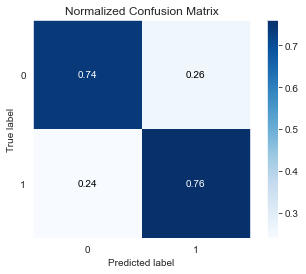

In [ ]:
xgb = XGBClassifier(min_child_weight=1,gamma=0.1, learning_rate = 0.1, max_depth=4,
                    n_estimators=50, random_state=42)

xgb.fit(X_resampled_smote, y_resampled_smote)


y_pred = xgb.predict(X_test)


print(classification_report(y_test, y_pred))
print('')
print("Recall: {:.4f}\n".format(recall_score(y_test, y_pred, average='macro')))
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))
print('')
# plotar matriz de confusão
plot_confusion_matrix(y_test, y_pred, normalize=True)
plt.show()

Como podemos ver ambos os modelos se comportaram de maneira semelhante. A escolha nesse caso seria sobre o XGB dado o seu custo computacional.

## Conclusões

* Apesar de relativamente limpo a fase exploratória demonstrou a necessidade de limpezas na base
* Essa fase também revelou a necessidade de balancear o dataset.
* Apesar de proceder à Standarização de algumas variáveis para facilitar a testagem dos modelos base dentro do pipeline essa fase não se faz necessária dentro dos modelos escolhidos
* Mesmo com a escolha e tunning dos hiperparâmetros no modelo AdaBoost ele não se mostrou suficientemente melhor que o modelo XGboost - que tem melhor performance computacional.
* O XGboost é o modelo escolhido nessa análise tanto pela performance de suas métricas quanto pelo poder computacional requerido. Isso mostra que mesmo a partir de uma base segura pode ser interessante testar modelos próximos (caso possível) - em termos algorítimicos - com otimização de seus hiperparâmetros para fazer uma verificação dupla.